## Forest Canopy Height and Density Estimation using LiDAR Data


## Table of Contents
* [Introduction](#1)
* [Connect to your GIS](#2)
* [Necessary Imports](#3)
* [Create LAS Dataset](#4) 
* [Forest Canopy Height Estimation](#5)
    * [Creating layers for ground point clouds from LAS Dataset](#6)
    * [Creating Digital Elevation Model from LiDAR point clouds](#7)
    * [Creating Surface Elevation Model from LiDAR point clouds](#8)
    * [Forest Height](#9)
* [Estimation of forest canopy density](#10)
    * [Create raster from LiDAR point clouds](#11)
    * [Create Null Rasters](#12)
    * [Create Total Count Raster](#13)
    * [Forest Canopy Density](#14)
* [Conclusion](#15)

## Introduction<a class="anchor" id="1"></a>

Forest canopy height and density are used as parameters for a number of environmental applications i.e. forest management, biodiversity determination, biomass estimation, vegetation coverage, etc. For forest studies ground surveys are hectic and time consuming due to the large extect and flora diversity so using remotely sensed data for analysis is a good alternative. Airborne Light Detection and Ranging (LiDAR) is also a good option for evaluating forest canopy parameters. This sample shows how forest canopy height and density can be estimated using LiDAR data and ArcGIS. 

## Necessary Imports<a class="anchor" id="3"></a>

In [1]:
from arcgis.raster.functions import con, is_null, FLOAT, colormap, remap, stretch
import arcpy

## Connect to your GIS<a class="anchor" id="2"></a>

In [2]:
from arcgis.gis import GIS
gis = GIS(profile="your_online_profile")

For the study LiDAR data from USGS was used. The LAS data was classified into different categories on the basis of returns. The time of data collection also plays an important role in forest management studies i.e. collecting the data in autumn will not give true results.

## Create LAS Dataset <a class="anchor" id="4"></a>

The LAS datasets has to be referenced using a geoprocessing tool. The tools for LAS dataset are not available in ArcGIS Python API so, arcpy tools has been used.

In [3]:
# Creating LAS dataset from raw LiDAR data
CreateLasDataset(r"Data\las_data", 
                 "forest.lasd", 
                 "NO_RECURSION", 
                 None, 
                 "PROJCS['NAD_1983_2011_UTM_Zone_19N',GEOGCS['GCS_NAD_1983_2011',DATUM['D_NAD_1983_2011',SPHEROID['GRS_1980',6378137.0,298.257222101]],PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]],PROJECTION['Transverse_Mercator'],PARAMETER['False_Easting',500000.0],PARAMETER['False_Northing',0.0],PARAMETER['Central_Meridian',-69.0],PARAMETER['Scale_Factor',0.9996],PARAMETER['Latitude_Of_Origin',0.0],UNIT['Meter',1.0]],VERTCS['NAVD88 height - Geoid12A (Meters)',VDATUM['North American Vertical Datum 1988'],UNIT['metre',1.0]]",
                 "COMPUTE_STATS",
                 "ABSOLUTE_PATHS", 
                 "NO_FILES")

## Forest Canopy Height Estimation<a class="anchor" id="5"></a>

### Creating layers for ground point clouds from LAS Dataset<a class="anchor" id="6"></a>

In [4]:
# Extracting ground point clouds from LAS dataset 
MakeLasDatasetLayer(in_las_dataset="forest2.lasd", 
                    out_layer=r"Data\groundtst", 
                    class_code='2', 
                    return_values=['Last return', 'Last of Many'], 
                    no_flag=True, 
                    synthetic=True, 
                    keypoint=True, 
                    withheld=False, 
                    overlap=True)

In [5]:
# Extracting 1st Return point clouds from LAS dataset
MakeLasDatasetLayer(in_las_dataset="forest.lasd", 
                    out_layer=r"Data\1st_return", 
                    return_values=['First of Many', '1'], 
                    no_flag=True, 
                    synthetic=True, 
                    keypoint=True, 
                    withheld=False, 
                    overlap=True)

### Creating Digital Elevation Model from LiDAR point clouds <a class="anchor" id="7"></a>

A DEM is a **bare earth** elevation model which does not include vegetation, buildings, and other **non ground** objects.

In [6]:
# Creating Digital Elevation Model (DEM) from ground point clouds
LasDatasetToRaster(in_las_dataset=r"C:\projects\LiDAR\Lidar_forest\output\groundtst", 
                   out_raster=r"Data\forest_dem.tif", 
                   value_field="ELEVATION", 
                   interpolation_type="BINNING AVERAGE LINEAR", 
                   data_type="FLOAT", 
                   sampling_type="CELLSIZE", 
                   sampling_value=1, 
                   z_factor=1)

In [7]:
dem = gis.content.get("8c892cd3660e41d9be630eda54cb168c")
dem

<Item title:"dem" type:Imagery Layer owner:priyankatuteja>

### Creating Surface Elevation Model from LiDAR point clouds<a class="anchor" id="8"></a>

A DSM is an elevation model that considers the **top of buildings, trees, powerlines, etc**. Commonly this is seen as a **canopy model** and only sees ground where there is nothing else overtop of it.

In [8]:
# Creating Digital Surface Model (DSM) from 1st return point clouds
arcpy.conversion.LasDatasetToRaster(in_las_dataset=r"Data\1st_return", 
                                    out_raster=r"Data\forest_dsm.tif", 
                                    value_field="ELEVATION", 
                                    interpolation_type="BINNING AVERAGE LINEAR", 
                                    data_type="FLOAT", 
                                    sampling_type="CELLSIZE", 
                                    sampling_value=1, 
                                    z_factor=1)

<Result 'C:\\projects\\LiDAR\\Lidar_forest\\output\\forest_dsm5.tif'>

In [9]:
dsm = gis.content.get("2cb50ead20a04966848b5253e5a98433")
dsm

<Item title:"dsm" type:Imagery Layer owner:priyankatuteja>

### Forest Height<a class="anchor" id="9"></a>

To determine canopy height, the bare earth surface raster (DEM) is substracted from the first return surface raster (DSM).

In [10]:
forest_height=(dsm.layers[0]-dem.layers[0])

In [11]:
ext = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
       'xmin': -7717906.2851893995,
       'ymin': 5653458.519130575,
       'xmax': -7715771.480220654,
       'ymax': 5655600.465243409}

In [12]:
m = gis.map('Salmon Stream, ME, USA')
m.add_layer(forest_height)
extent = ext
m.legend = True
m

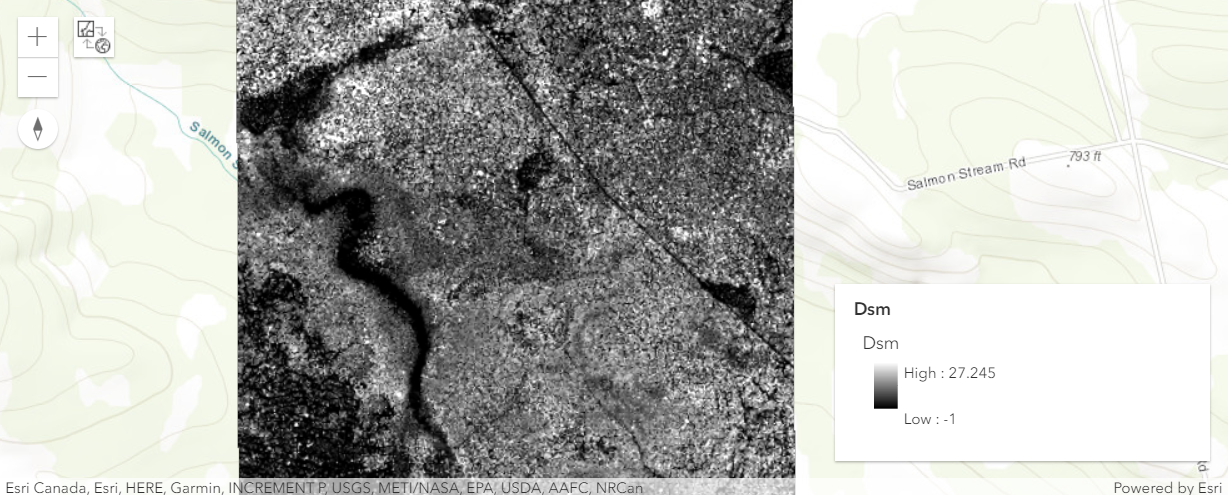

The forest height raster has values ranging from -1 to 28m. negative values represesnts waterbodies. To make the symbology more informative `Stretch` function was used on the forest height raster.

In [13]:
forest_height_layer = forest_height
forest_height_op = stretch(forest_height_layer, 
                           stretch_type='percentclip', 
                           min_percent=0.1, 
                           max_percent=0.1, 
                           gamma=[1, 1, 1], 
                           dra=True)
forest_hgt_colormap = colormap(forest_height_op, 
                               colorramp="Slope")

In [14]:
m = gis.map('Salmon Stream, ME, USA')
m.add_layer(forest_hgt_colormap)
m

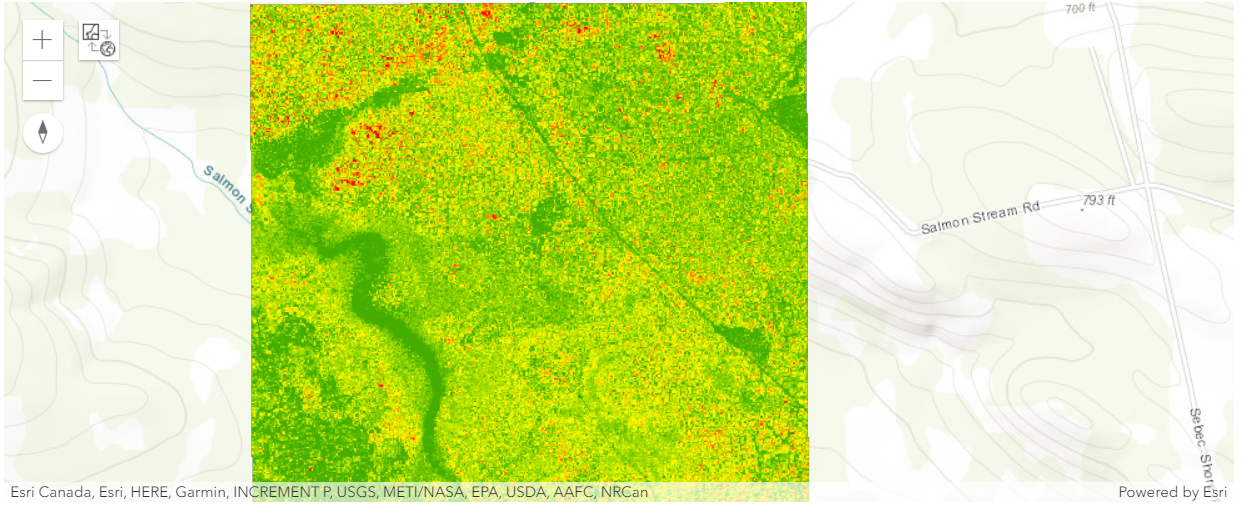

The above raster is showing the tree heights and the height of trees decreases from **Red** to **Green** color.

## Estimation of  forest canopy density<a class="anchor" id="10"></a>

The literature suggests that for canopy density estimation the most widely accepted way is by dividing the study area into small units using rasterization. In raster it is easy to do overlay analaysis. The forest canopy density is estimated by diving the above ground points with the total number of points.

### Create raster from LiDAR point clouds<a class="anchor" id="11"></a>

Raster for both above the ground and ground points has been created from the LAS points using `Las Point Stats as Raster`.

In [15]:
##Arcpy code for creating raster of above ground points
LasPointStatsAsRaster(in_las_dataset="..\forest.lasd", 
                      out_raster=r"..\forest_avgd.tif", 
                      method="POINT_COUNT", 
                      sampling_type="CELLSIZE", 
                      sampling_value=1)

<Result 'C:\\projects\\LiDAR\\Lidar_forest\\output\\forest_avgd4.tif'>

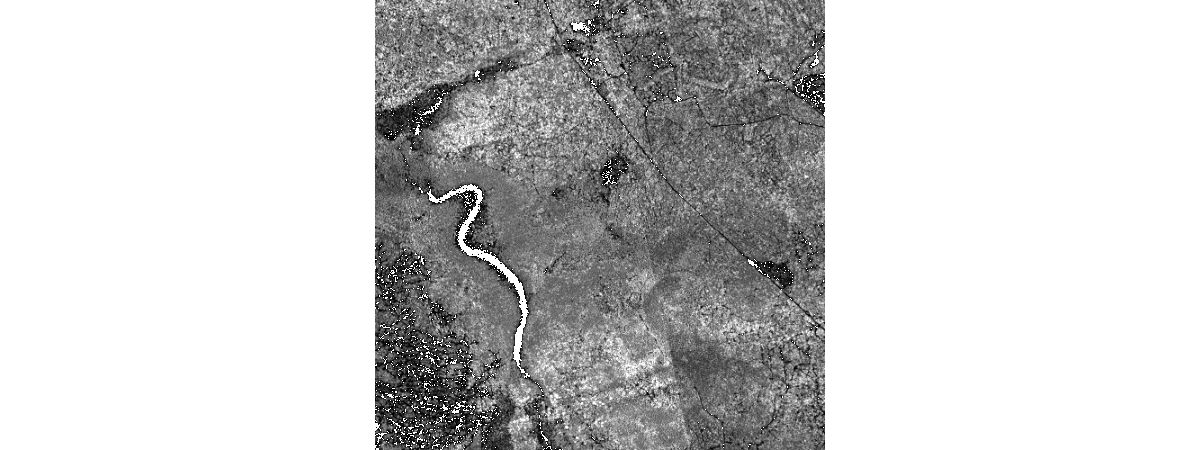

In [16]:
above_ground = gis.content.get("82a1fe801b564a838a2f3835f8eeb18c")
avgd_point=above_ground.layers[0]
avgd_point

In [17]:
#Arcpy code for creating raster of ground points
LasPointStatsAsRaster(in_las_dataset=r"..\forest.lasd", 
                      out_raster=r"=..\forest_grd.tif", 
                      method="POINT_COUNT", 
                      sampling_type="CELLSIZE", 
                      sampling_value=1)

<Result 'C:\\projects\\LiDAR\\Lidar_forest\\output\\forest_grd2.tif'>

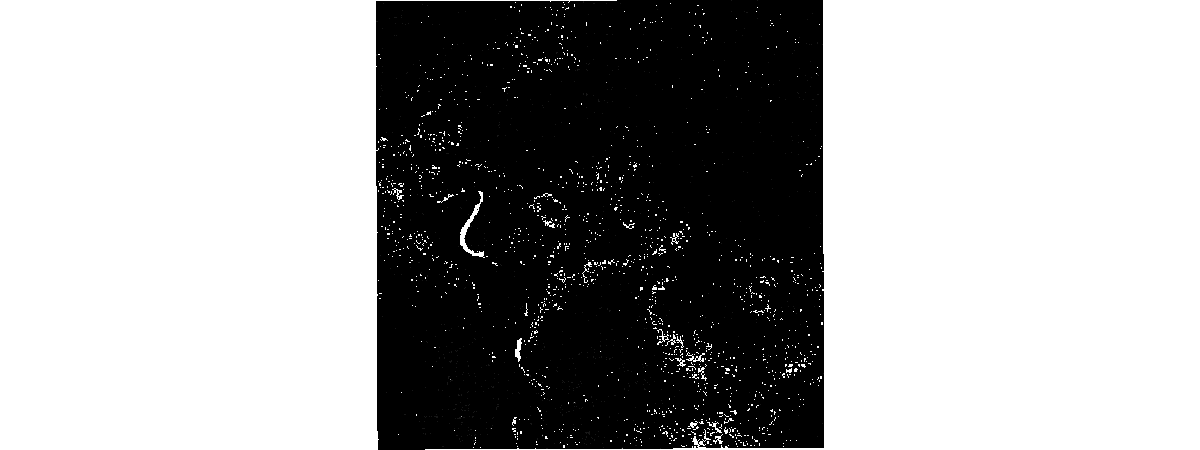

In [18]:
ground = gis.content.get("dcb83ae620b64b2d8554e61076d43660")
gd_points=ground.layers[0]
gd_points

In [19]:
true=gis.content.get("e0f03e418e5542af9e8f0df99c66c178")
true_raster=true.layers[0]

### Create Null Rasters<a class="anchor" id="12"></a>

`Null` function was used to convert the *No Data* cells into 0 so that it can be used to estimated canopy density.

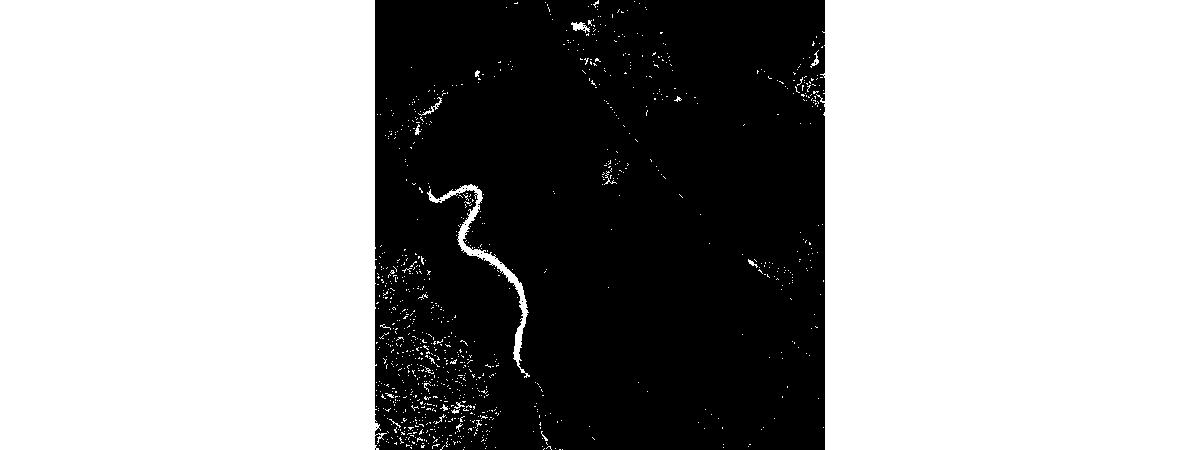

In [20]:
null_avgd_raster=is_null([above_ground.layers[0]], cellsize_type='MaxOf', astype="U1")
null_avgd_raster

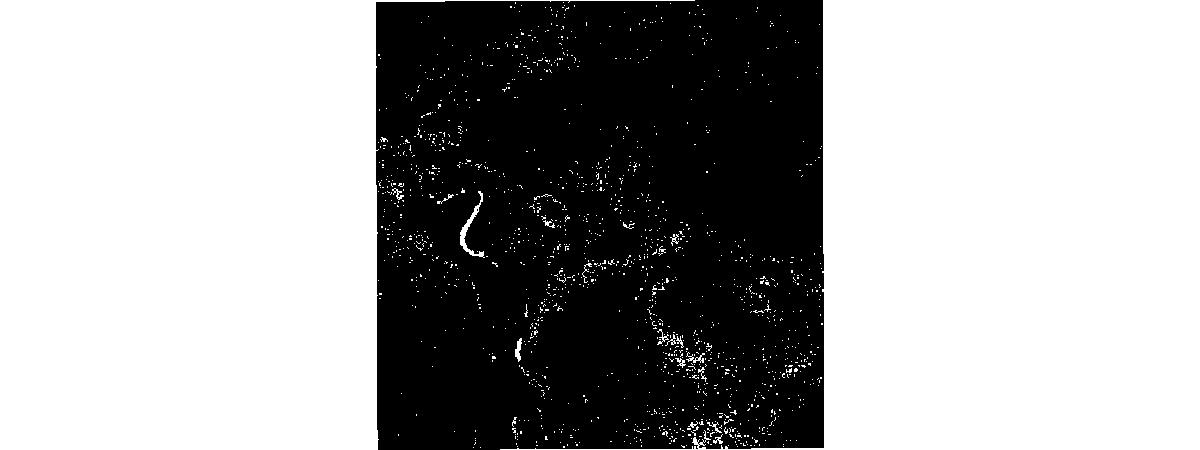

In [21]:
null_grd = is_null([ground.layers[0]], cellsize_type='MaxOf', astype="U1")
null_grd

### Create Total Count Raster<a class="anchor" id="13"></a>

After `Null`, next step was to create a raster which has the orginal *avgd_point* raster values if the *Null* raster was false. For this step `Con` function was used.

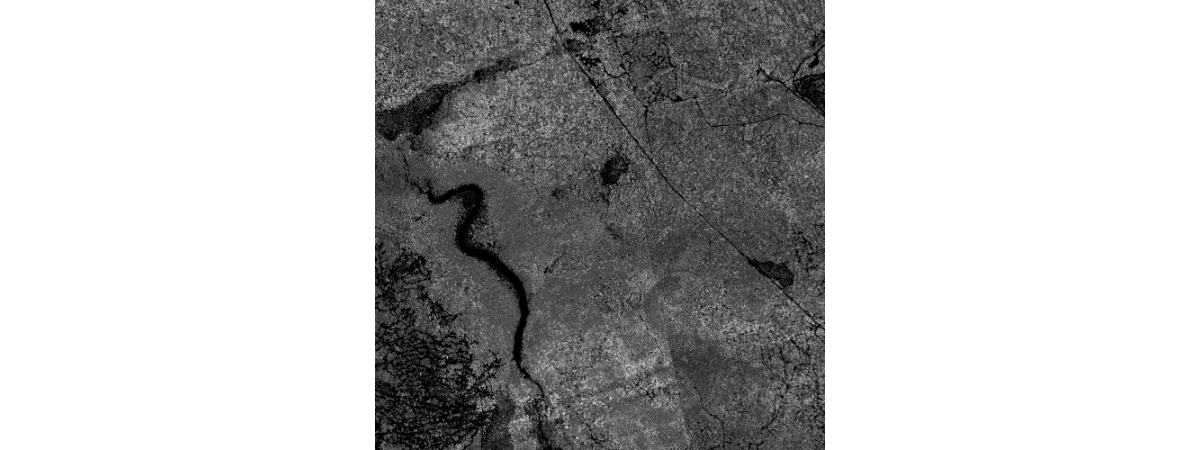

In [22]:
con_avgd = con([null_avgd_raster, true_raster, avgd_point], extent_type='FirstOf', cellsize_type='FirstOf', astype="U1")
con_avgd

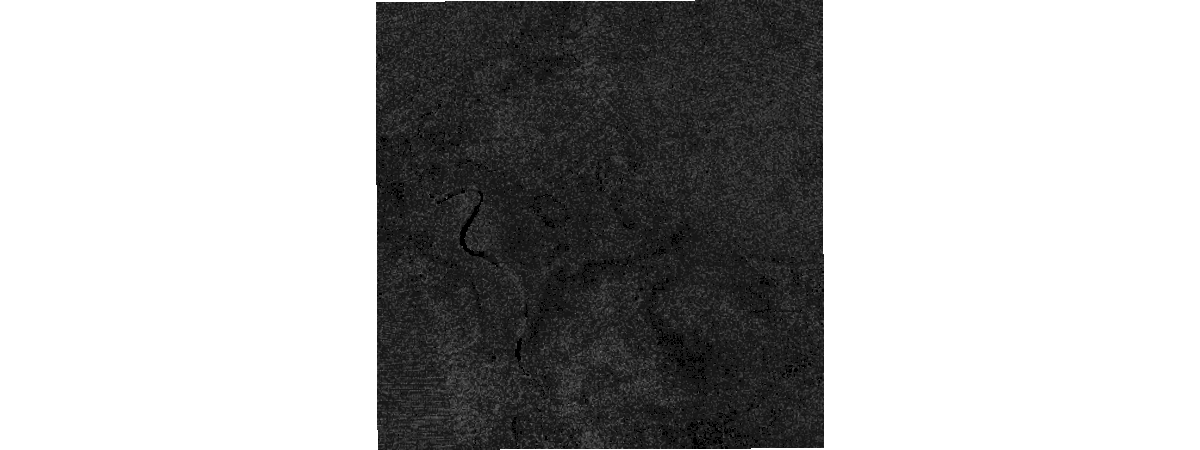

In [23]:
con_grd=con([null_grd, true_raster, gd_points], extent_type='FirstOf', cellsize_type='FirstOf', astype="U1")
con_grd

The *ground raster* and *above ground* raster were added using `map algebra` to create *total count* raster.

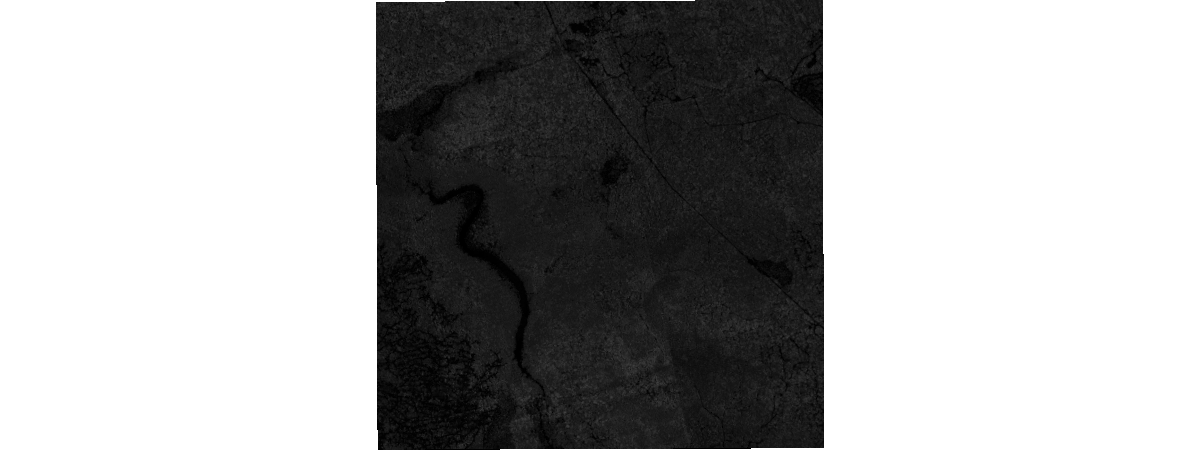

In [24]:
total_count=(con_grd+con_avgd)
total_count

The density raster has to be **Float**. So, the *total count* raster was converted into float using `FLOAT` function.

In [25]:
float_tcount=FLOAT([total_count], extent_type='FirstOf', cellsize_type='FirstOf', astype='U1')

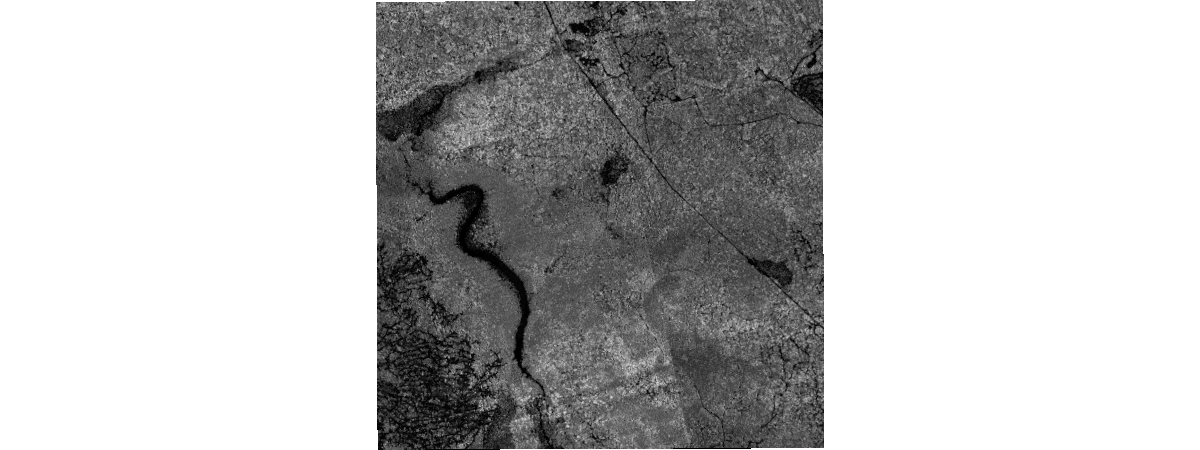

In [26]:
float_tcount

### Forest Canopy Density<a class="anchor" id="14"></a>

The forest canopy density is calculated by dividing, *above ground point* raster with *total count* raster. This will return raster which has values ranging from 0.0 to 1.0. The pixels with 0.0 value represents *no vegetation* and it increases the vegetation density also increases and 1.0 shows *very dense canopy*.

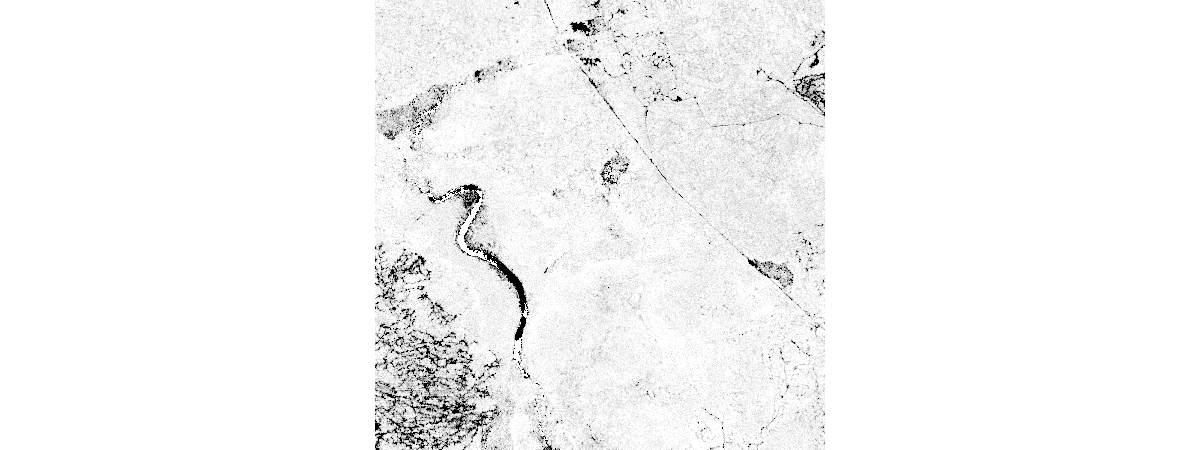

In [27]:
forest_density=(con_avgd/float_tcount)
forest_density

In [28]:
canopy_density = remap(forest_density,
                       input_ranges=[-1, 0, # No vegetation
                                     0, 0.2,# Very Low Density
                                     0.2, 0.4, # Low Density
                                     0.4, 0.6, # Moderate Density
                                     0.6, 0.8, # High Density
                                     0.8, 1.0], # Very High Density
                       output_values=[1, 2, 3, 4, 5, 6],
                       astype='u8')
                                                                          

In [29]:
forest_canopy_density = colormap(canopy_density,
                                 colormap = [[1, 255, 255, 0], [2, 173, 255, 47],
                                             [3, 154, 205, 50], [4, 50, 205, 50], 
                                             [5, 0, 128, 0], [6, 0, 100, 0]],
                                 astype='u8')                                

In [30]:
m = gis.map('Salmon Stream, ME, USA')
m.add_layer(forest_canopy_density)
m.legend = True
m

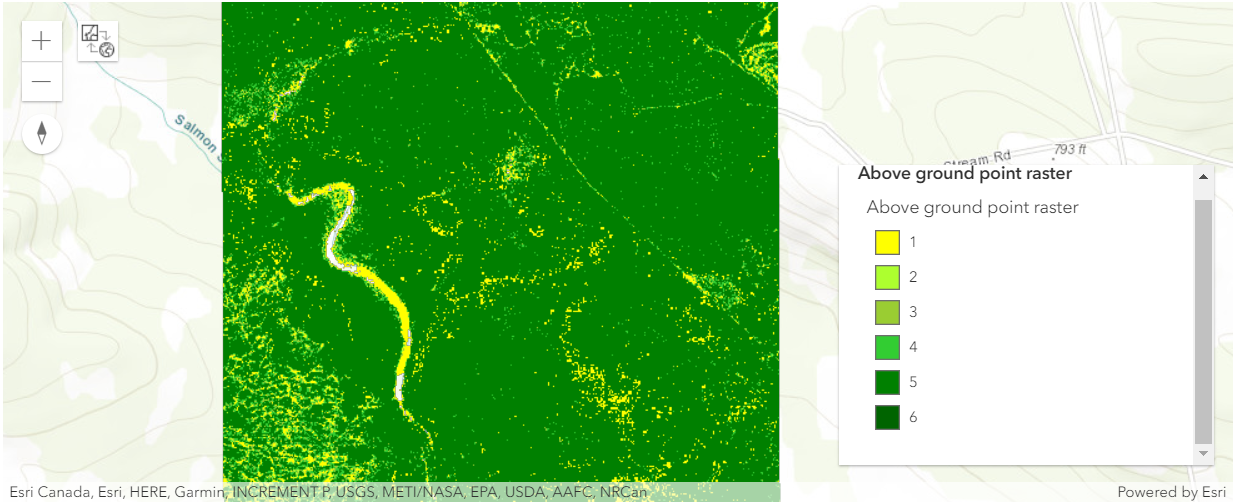

The forest canopy density raster is reclassified into 6 classes based on the canopy density. The Classes are as follows:
1 = No vegetation
2 = Very low canopy density
3 = Low canopy density
4 = Moderate canopy density
5= High canopy density
6 = Very High canopy density

### Conclusion<a class="anchor" id="15"></a>

The study concludes that LiDAR is a good alternative technique for forest management studies. The same workflow can be used on different areas for forest height and forest canopy density estimation. The same workflow can be used to estimate the changes in the canopy density after any forest fire event or any other disaster to estimate the loss.